<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/AE_HYBRID_LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
criterion = nn.MSELoss()
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
DATA_SONG_DIR = "48Bins"
DATA_IMG_DIR = "48Bins"

files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_mel_numpy"):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_mel_numpy"])
    else:
      print(file)

random.seed(1234)
files = random.sample(files, 2008)

for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Indian_mel_numpy"):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_mel_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
data.head()

,Images,songs,labels
0,039357.npy,039357.npy,Western_mel_numpy
1,107591.npy,107591.npy,Western_mel_numpy
2,143217.npy,143217.npy,Western_mel_numpy
3,140623.npy,140623.npy,Western_mel_numpy
4,147059.npy,147059.npy,Western_mel_numpy


In [5]:
data.groupby("labels").count()

,Images,songs
labels,,
Indian_mel_numpy,2008,2008
Western_mel_numpy,2008,2008


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_mel_numpy/122646.npy
80.0


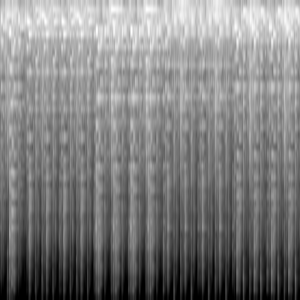

In [6]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, data.loc[test_idx, 'labels'], data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



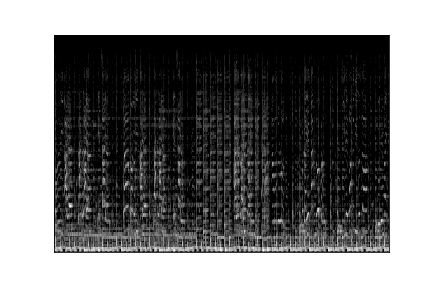

In [7]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [8]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,songs,labels,encoded_labels
0,039357.npy,039357.npy,Western_mel_numpy,1
1,107591.npy,107591.npy,Western_mel_numpy,1
2,143217.npy,143217.npy,Western_mel_numpy,1
3,140623.npy,140623.npy,Western_mel_numpy,1
4,147059.npy,147059.npy,Western_mel_numpy,1


In [9]:
classes = ('Indian_numpy', 'Western_numpy')
data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_mel_numpy,0,2008,2008
Western_mel_numpy,1,2008,2008


In [10]:
from sklearn.model_selection import train_test_split

data = data.sample(frac=1)
df_train, df_test = train_test_split(data, test_size=validation_split, stratify=data[["labels"]])

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_mel_numpy,0,1406,1406
Western_mel_numpy,1,1405,1405


In [12]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_mel_numpy,0,602,602
Western_mel_numpy,1,603,603


In [13]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [14]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        return data, label



In [15]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [16]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [24]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

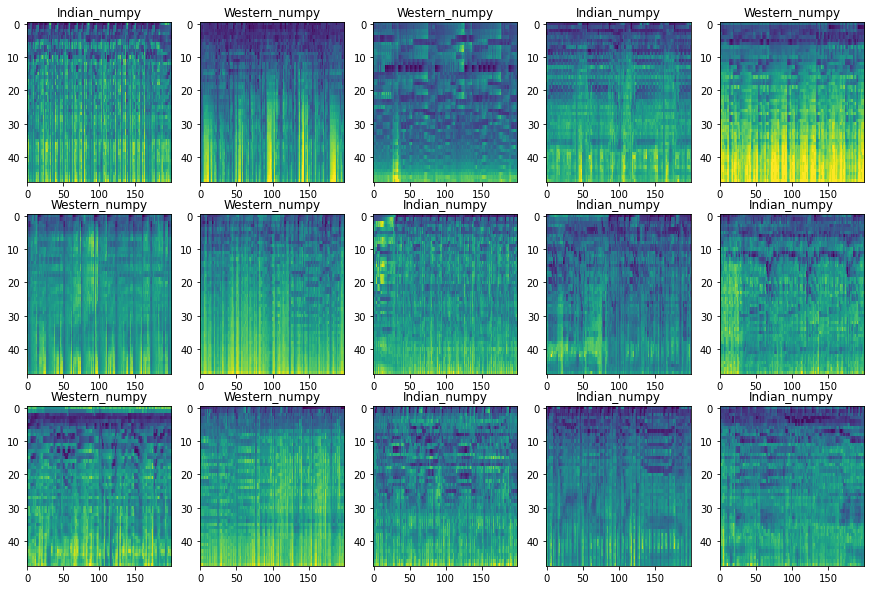

In [25]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

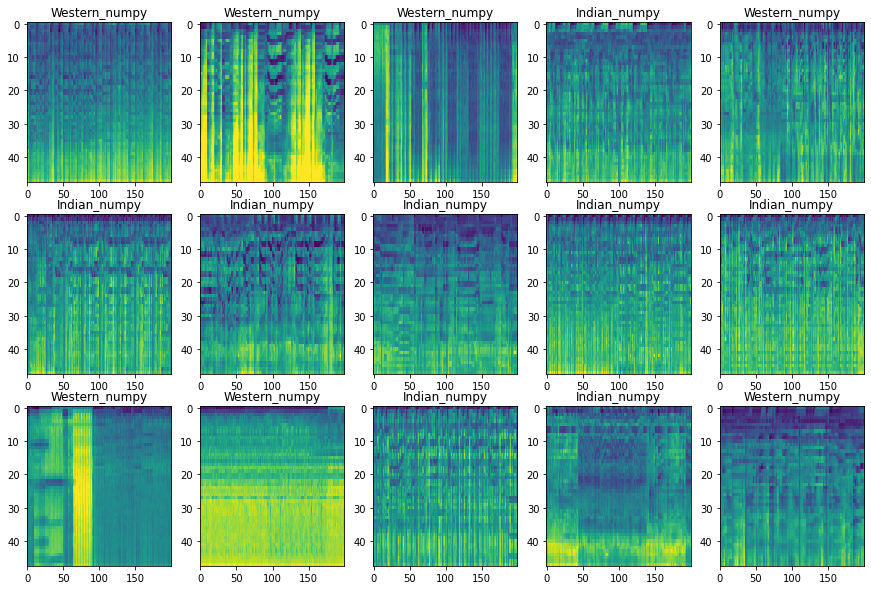

In [26]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [27]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [28]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1300.926
[1,     2] loss: 1027.181
[1,     3] loss: 1080.187
[1,     4] loss: 979.436
[1,     5] loss: 581.993
[1,     6] loss: 360.056
[1,     7] loss: 205.985
[1,     8] loss: 576.582
[1,     9] loss: 302.589
[1,    10] loss: 134.940
[1,    11] loss: 153.178
[1,    12] loss: 126.810
[1,    13] loss: 193.192
[1,    14] loss: 232.046
[1,    15] loss: 218.975
[1,    16] loss: 217.550
[1,    17] loss: 152.856
[1,    18] loss: 165.846
[1,    19] loss: 134.222
[1,    20] loss: 133.429
[1,    21] loss: 142.224
[1,    22] loss: 154.722
[1,    23] loss: 167.631
[1,    24] loss: 167.304
[1,    25] loss: 132.411
[1,    26] loss: 140.215
[1,    27] loss: 140.559
[1,    28] loss: 135.405
[1,    29] loss: 125.025
[1,    30] loss: 114.075
[1,    31] loss: 99.398
[1,    32] loss: 128.829
[1,    33] loss: 154.802
[1,    34] loss: 108.066
[1,    35] loss: 98.694
[1,    36] loss: 117.881
[1,    37] loss: 106.219
[1,    38] loss: 136.973
[1,    39] loss: 93.177
[1,    40] loss: 115.696


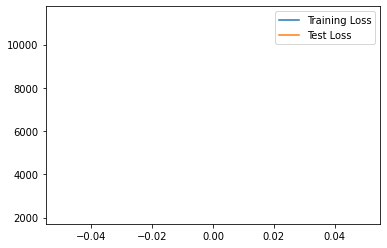

[2,     1] loss: 109.416
[2,     2] loss: 85.976
[2,     3] loss: 110.514
[2,     4] loss: 138.119
[2,     5] loss: 99.820
[2,     6] loss: 109.118
[2,     7] loss: 123.753
[2,     8] loss: 113.037
[2,     9] loss: 112.009
[2,    10] loss: 103.336
[2,    11] loss: 123.807
[2,    12] loss: 88.745
[2,    13] loss: 100.846
[2,    14] loss: 106.164
[2,    15] loss: 98.307
[2,    16] loss: 112.009
[2,    17] loss: 94.316
[2,    18] loss: 110.920
[2,    19] loss: 106.820
[2,    20] loss: 108.872
[2,    21] loss: 108.407
[2,    22] loss: 107.414
[2,    23] loss: 122.854
[2,    24] loss: 111.613
[2,    25] loss: 90.242
[2,    26] loss: 109.702
[2,    27] loss: 121.788
[2,    28] loss: 122.365
[2,    29] loss: 111.127
[2,    30] loss: 103.106
[2,    31] loss: 90.877
[2,    32] loss: 108.200
[2,    33] loss: 128.995
[2,    34] loss: 90.366
[2,    35] loss: 88.413
[2,    36] loss: 100.681
[2,    37] loss: 90.929
[2,    38] loss: 112.860
[2,    39] loss: 78.733
[2,    40] loss: 97.652
[2,    41] l

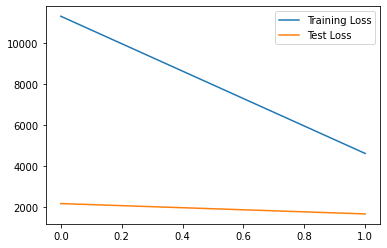

[3,     1] loss: 81.275
[3,     2] loss: 64.014
[3,     3] loss: 85.991
[3,     4] loss: 90.545
[3,     5] loss: 77.695
[3,     6] loss: 76.937
[3,     7] loss: 76.549
[3,     8] loss: 70.759
[3,     9] loss: 85.818
[3,    10] loss: 74.079
[3,    11] loss: 76.947
[3,    12] loss: 71.535
[3,    13] loss: 71.276
[3,    14] loss: 77.708
[3,    15] loss: 69.455
[3,    16] loss: 77.411
[3,    17] loss: 69.223
[3,    18] loss: 73.173
[3,    19] loss: 76.645
[3,    20] loss: 73.394
[3,    21] loss: 74.647
[3,    22] loss: 71.197
[3,    23] loss: 82.127
[3,    24] loss: 75.954
[3,    25] loss: 70.456
[3,    26] loss: 71.892
[3,    27] loss: 84.116
[3,    28] loss: 79.458
[3,    29] loss: 73.803
[3,    30] loss: 72.312
[3,    31] loss: 68.062
[3,    32] loss: 76.073
[3,    33] loss: 76.831
[3,    34] loss: 60.148
[3,    35] loss: 70.943
[3,    36] loss: 74.101
[3,    37] loss: 67.043
[3,    38] loss: 71.255
[3,    39] loss: 61.583
[3,    40] loss: 79.351
[3,    41] loss: 70.035
[3,    42] loss:

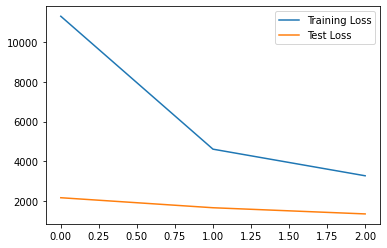

[4,     1] loss: 66.713
[4,     2] loss: 54.759
[4,     3] loss: 72.205
[4,     4] loss: 77.050
[4,     5] loss: 66.916
[4,     6] loss: 73.373
[4,     7] loss: 65.494
[4,     8] loss: 68.242
[4,     9] loss: 74.946
[4,    10] loss: 66.735
[4,    11] loss: 73.148
[4,    12] loss: 64.268
[4,    13] loss: 67.935
[4,    14] loss: 72.562
[4,    15] loss: 65.578
[4,    16] loss: 74.953
[4,    17] loss: 64.447
[4,    18] loss: 70.957
[4,    19] loss: 72.394
[4,    20] loss: 72.524
[4,    21] loss: 71.233
[4,    22] loss: 69.038
[4,    23] loss: 80.229
[4,    24] loss: 73.384
[4,    25] loss: 69.494
[4,    26] loss: 70.296
[4,    27] loss: 82.589
[4,    28] loss: 77.744
[4,    29] loss: 73.150
[4,    30] loss: 71.380
[4,    31] loss: 67.475
[4,    32] loss: 75.297
[4,    33] loss: 75.709
[4,    34] loss: 59.524
[4,    35] loss: 70.199
[4,    36] loss: 73.439
[4,    37] loss: 66.025
[4,    38] loss: 70.566
[4,    39] loss: 60.904
[4,    40] loss: 78.676
[4,    41] loss: 69.243
[4,    42] loss:

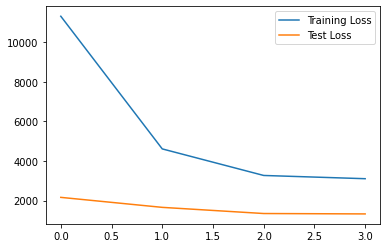

[5,     1] loss: 65.680
[5,     2] loss: 54.550
[5,     3] loss: 70.983
[5,     4] loss: 76.275
[5,     5] loss: 65.524
[5,     6] loss: 73.031
[5,     7] loss: 64.406
[5,     8] loss: 68.185
[5,     9] loss: 74.258
[5,    10] loss: 66.701
[5,    11] loss: 72.816
[5,    12] loss: 63.610
[5,    13] loss: 67.387
[5,    14] loss: 72.145
[5,    15] loss: 65.194
[5,    16] loss: 74.162
[5,    17] loss: 63.892
[5,    18] loss: 70.810
[5,    19] loss: 71.886
[5,    20] loss: 72.218
[5,    21] loss: 70.977
[5,    22] loss: 68.581
[5,    23] loss: 80.150
[5,    24] loss: 72.708
[5,    25] loss: 69.274
[5,    26] loss: 69.700
[5,    27] loss: 82.028
[5,    28] loss: 77.017
[5,    29] loss: 72.738
[5,    30] loss: 70.978
[5,    31] loss: 67.426
[5,    32] loss: 74.902
[5,    33] loss: 75.081
[5,    34] loss: 59.230
[5,    35] loss: 69.978
[5,    36] loss: 73.155
[5,    37] loss: 65.591
[5,    38] loss: 70.069
[5,    39] loss: 60.567
[5,    40] loss: 78.184
[5,    41] loss: 68.961
[5,    42] loss:

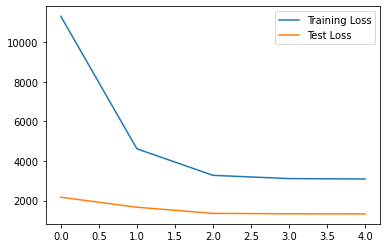

[6,     1] loss: 65.249
[6,     2] loss: 54.219
[6,     3] loss: 70.724
[6,     4] loss: 75.757
[6,     5] loss: 65.238
[6,     6] loss: 72.499
[6,     7] loss: 63.976
[6,     8] loss: 67.740
[6,     9] loss: 74.040
[6,    10] loss: 66.156
[6,    11] loss: 72.727
[6,    12] loss: 63.497
[6,    13] loss: 67.091
[6,    14] loss: 71.685
[6,    15] loss: 64.741
[6,    16] loss: 73.974
[6,    17] loss: 63.573
[6,    18] loss: 70.273
[6,    19] loss: 71.333
[6,    20] loss: 71.644
[6,    21] loss: 70.143
[6,    22] loss: 68.147
[6,    23] loss: 79.443
[6,    24] loss: 72.527
[6,    25] loss: 68.708
[6,    26] loss: 69.339
[6,    27] loss: 81.278
[6,    28] loss: 76.470
[6,    29] loss: 72.328
[6,    30] loss: 70.596
[6,    31] loss: 67.091
[6,    32] loss: 74.459
[6,    33] loss: 74.563
[6,    34] loss: 58.890
[6,    35] loss: 69.807
[6,    36] loss: 72.848
[6,    37] loss: 65.166
[6,    38] loss: 69.731
[6,    39] loss: 60.208
[6,    40] loss: 77.703
[6,    41] loss: 68.699
[6,    42] loss:

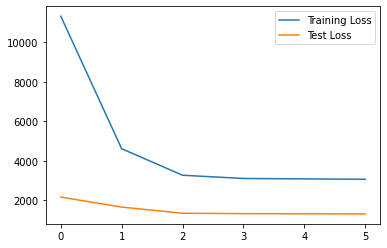

[7,     1] loss: 64.858
[7,     2] loss: 53.944
[7,     3] loss: 70.542
[7,     4] loss: 75.260
[7,     5] loss: 65.017
[7,     6] loss: 71.916
[7,     7] loss: 63.570
[7,     8] loss: 67.297
[7,     9] loss: 73.578
[7,    10] loss: 65.771
[7,    11] loss: 71.965
[7,    12] loss: 63.492
[7,    13] loss: 66.700
[7,    14] loss: 71.343
[7,    15] loss: 64.268
[7,    16] loss: 73.457
[7,    17] loss: 63.576
[7,    18] loss: 70.142
[7,    19] loss: 70.770
[7,    20] loss: 71.476
[7,    21] loss: 69.566
[7,    22] loss: 67.685
[7,    23] loss: 79.198
[7,    24] loss: 72.027
[7,    25] loss: 68.300
[7,    26] loss: 68.820
[7,    27] loss: 80.648
[7,    28] loss: 75.941
[7,    29] loss: 71.963
[7,    30] loss: 70.229
[7,    31] loss: 66.922
[7,    32] loss: 73.979
[7,    33] loss: 74.015
[7,    34] loss: 58.593
[7,    35] loss: 69.545
[7,    36] loss: 72.544
[7,    37] loss: 64.659
[7,    38] loss: 69.262
[7,    39] loss: 59.912
[7,    40] loss: 77.111
[7,    41] loss: 68.429
[7,    42] loss:

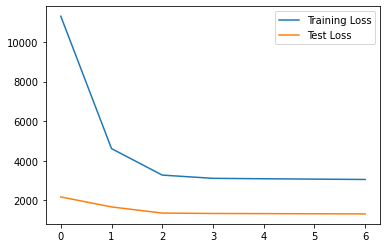

[8,     1] loss: 64.321
[8,     2] loss: 53.644
[8,     3] loss: 70.185
[8,     4] loss: 74.700
[8,     5] loss: 64.779
[8,     6] loss: 71.306
[8,     7] loss: 63.121
[8,     8] loss: 67.028
[8,     9] loss: 73.088
[8,    10] loss: 65.382
[8,    11] loss: 71.400
[8,    12] loss: 63.296
[8,    13] loss: 66.405
[8,    14] loss: 70.778
[8,    15] loss: 64.015
[8,    16] loss: 72.892
[8,    17] loss: 63.207
[8,    18] loss: 70.335
[8,    19] loss: 70.203
[8,    20] loss: 71.134
[8,    21] loss: 69.601
[8,    22] loss: 67.164
[8,    23] loss: 78.956
[8,    24] loss: 72.302
[8,    25] loss: 67.723
[8,    26] loss: 68.756
[8,    27] loss: 80.135
[8,    28] loss: 75.468
[8,    29] loss: 71.937
[8,    30] loss: 69.931
[8,    31] loss: 66.692
[8,    32] loss: 73.407
[8,    33] loss: 73.408
[8,    34] loss: 58.426
[8,    35] loss: 69.183
[8,    36] loss: 72.266
[8,    37] loss: 64.183
[8,    38] loss: 68.649
[8,    39] loss: 59.670
[8,    40] loss: 76.367
[8,    41] loss: 67.979
[8,    42] loss:

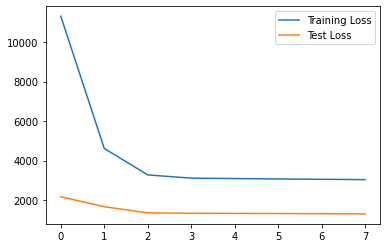

[9,     1] loss: 63.546
[9,     2] loss: 53.319
[9,     3] loss: 69.680
[9,     4] loss: 73.799
[9,     5] loss: 64.463
[9,     6] loss: 70.410
[9,     7] loss: 62.754
[9,     8] loss: 66.559
[9,     9] loss: 72.358
[9,    10] loss: 64.838
[9,    11] loss: 70.489
[9,    12] loss: 62.625
[9,    13] loss: 65.904
[9,    14] loss: 69.973
[9,    15] loss: 63.432
[9,    16] loss: 72.250
[9,    17] loss: 62.308
[9,    18] loss: 69.784
[9,    19] loss: 69.210
[9,    20] loss: 69.826
[9,    21] loss: 68.560
[9,    22] loss: 66.347
[9,    23] loss: 77.206
[9,    24] loss: 71.069
[9,    25] loss: 66.866
[9,    26] loss: 66.904
[9,    27] loss: 78.595
[9,    28] loss: 74.212
[9,    29] loss: 70.575
[9,    30] loss: 69.072
[9,    31] loss: 66.176
[9,    32] loss: 72.060
[9,    33] loss: 72.249
[9,    34] loss: 57.780
[9,    35] loss: 68.305
[9,    36] loss: 71.122
[9,    37] loss: 62.970
[9,    38] loss: 67.812
[9,    39] loss: 58.439
[9,    40] loss: 74.699
[9,    41] loss: 66.667
[9,    42] loss:

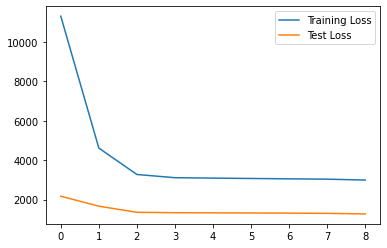

[10,     1] loss: 62.030
[10,     2] loss: 52.827
[10,     3] loss: 67.982
[10,     4] loss: 71.152
[10,     5] loss: 63.143
[10,     6] loss: 68.233
[10,     7] loss: 62.012
[10,     8] loss: 65.808
[10,     9] loss: 70.307
[10,    10] loss: 62.443
[10,    11] loss: 68.382
[10,    12] loss: 59.660
[10,    13] loss: 63.991
[10,    14] loss: 68.467
[10,    15] loss: 61.220
[10,    16] loss: 70.335
[10,    17] loss: 59.477
[10,    18] loss: 66.752
[10,    19] loss: 65.001
[10,    20] loss: 66.072
[10,    21] loss: 64.594
[10,    22] loss: 62.649
[10,    23] loss: 72.316
[10,    24] loss: 67.666
[10,    25] loss: 64.806
[10,    26] loss: 63.698
[10,    27] loss: 73.456
[10,    28] loss: 70.592
[10,    29] loss: 67.283
[10,    30] loss: 66.404
[10,    31] loss: 64.552
[10,    32] loss: 71.935
[10,    33] loss: 69.925
[10,    34] loss: 54.381
[10,    35] loss: 65.811
[10,    36] loss: 69.843
[10,    37] loss: 59.738
[10,    38] loss: 64.109
[10,    39] loss: 56.628
[10,    40] loss: 70.491


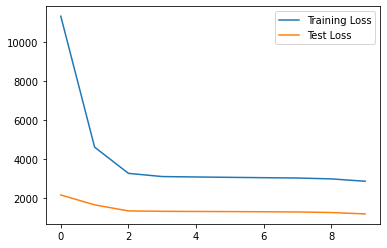

[11,     1] loss: 59.379
[11,     2] loss: 51.592
[11,     3] loss: 62.740
[11,     4] loss: 64.343
[11,     5] loss: 59.564
[11,     6] loss: 64.530
[11,     7] loss: 60.135
[11,     8] loss: 60.253
[11,     9] loss: 65.692
[11,    10] loss: 58.536
[11,    11] loss: 64.531
[11,    12] loss: 57.393
[11,    13] loss: 61.508
[11,    14] loss: 64.902
[11,    15] loss: 57.620
[11,    16] loss: 66.046
[11,    17] loss: 56.544
[11,    18] loss: 63.448
[11,    19] loss: 59.308
[11,    20] loss: 62.439
[11,    21] loss: 62.645
[11,    22] loss: 57.652
[11,    23] loss: 66.976
[11,    24] loss: 63.988
[11,    25] loss: 60.427
[11,    26] loss: 59.740
[11,    27] loss: 68.126
[11,    28] loss: 66.769
[11,    29] loss: 63.818
[11,    30] loss: 63.568
[11,    31] loss: 60.455
[11,    32] loss: 65.371
[11,    33] loss: 62.901
[11,    34] loss: 52.780
[11,    35] loss: 62.315
[11,    36] loss: 65.799
[11,    37] loss: 56.501
[11,    38] loss: 62.075
[11,    39] loss: 53.195
[11,    40] loss: 66.047


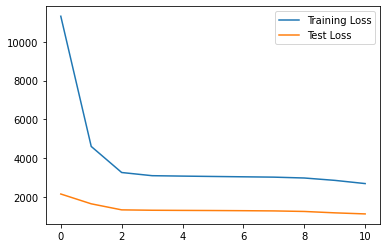

[12,     1] loss: 57.326
[12,     2] loss: 49.951
[12,     3] loss: 60.264
[12,     4] loss: 60.882
[12,     5] loss: 57.698
[12,     6] loss: 60.526
[12,     7] loss: 56.784
[12,     8] loss: 58.345
[12,     9] loss: 62.308
[12,    10] loss: 55.695
[12,    11] loss: 61.911
[12,    12] loss: 54.725
[12,    13] loss: 60.173
[12,    14] loss: 63.773
[12,    15] loss: 54.963
[12,    16] loss: 64.463
[12,    17] loss: 54.814
[12,    18] loss: 61.089
[12,    19] loss: 57.245
[12,    20] loss: 60.108
[12,    21] loss: 59.595
[12,    22] loss: 56.272
[12,    23] loss: 65.018
[12,    24] loss: 61.822
[12,    25] loss: 58.180
[12,    26] loss: 58.461
[12,    27] loss: 66.120
[12,    28] loss: 64.547
[12,    29] loss: 62.210
[12,    30] loss: 61.630
[12,    31] loss: 59.408
[12,    32] loss: 64.845
[12,    33] loss: 62.708
[12,    34] loss: 52.176
[12,    35] loss: 61.301
[12,    36] loss: 65.172
[12,    37] loss: 55.339
[12,    38] loss: 60.991
[12,    39] loss: 53.144
[12,    40] loss: 64.427


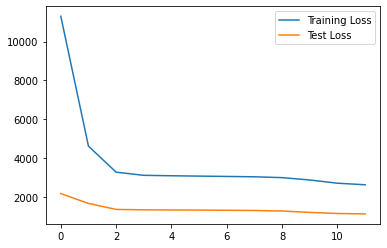

[13,     1] loss: 56.308
[13,     2] loss: 48.883
[13,     3] loss: 59.445
[13,     4] loss: 60.487
[13,     5] loss: 56.520
[13,     6] loss: 59.621
[13,     7] loss: 56.927
[13,     8] loss: 57.294
[13,     9] loss: 61.338
[13,    10] loss: 54.618
[13,    11] loss: 60.454
[13,    12] loss: 55.028
[13,    13] loss: 58.569
[13,    14] loss: 63.549
[13,    15] loss: 55.010
[13,    16] loss: 63.015
[13,    17] loss: 56.214
[13,    18] loss: 60.143
[13,    19] loss: 56.260
[13,    20] loss: 60.073
[13,    21] loss: 57.575
[13,    22] loss: 55.286
[13,    23] loss: 63.365
[13,    24] loss: 60.621
[13,    25] loss: 57.209
[13,    26] loss: 57.025
[13,    27] loss: 64.509
[13,    28] loss: 62.854
[13,    29] loss: 61.017
[13,    30] loss: 59.502
[13,    31] loss: 58.664
[13,    32] loss: 63.621
[13,    33] loss: 59.629
[13,    34] loss: 50.878
[13,    35] loss: 60.070
[13,    36] loss: 62.860
[13,    37] loss: 54.309
[13,    38] loss: 59.706
[13,    39] loss: 50.609
[13,    40] loss: 62.290


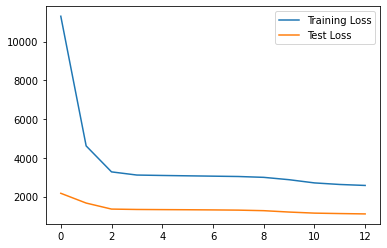

[14,     1] loss: 55.399
[14,     2] loss: 48.069
[14,     3] loss: 58.203
[14,     4] loss: 58.717
[14,     5] loss: 55.295
[14,     6] loss: 57.475
[14,     7] loss: 55.378
[14,     8] loss: 56.467
[14,     9] loss: 59.332
[14,    10] loss: 53.325
[14,    11] loss: 58.256
[14,    12] loss: 51.660
[14,    13] loss: 57.379
[14,    14] loss: 60.584
[14,    15] loss: 52.693
[14,    16] loss: 61.101
[14,    17] loss: 53.230
[14,    18] loss: 58.794
[14,    19] loss: 53.676
[14,    20] loss: 57.872
[14,    21] loss: 56.060
[14,    22] loss: 53.313
[14,    23] loss: 61.795
[14,    24] loss: 59.164
[14,    25] loss: 55.368
[14,    26] loss: 55.517
[14,    27] loss: 62.316
[14,    28] loss: 61.182
[14,    29] loss: 59.482
[14,    30] loss: 57.921
[14,    31] loss: 57.050
[14,    32] loss: 62.239
[14,    33] loss: 58.810
[14,    34] loss: 49.887
[14,    35] loss: 58.293
[14,    36] loss: 61.679
[14,    37] loss: 52.596
[14,    38] loss: 58.394
[14,    39] loss: 50.496
[14,    40] loss: 60.607


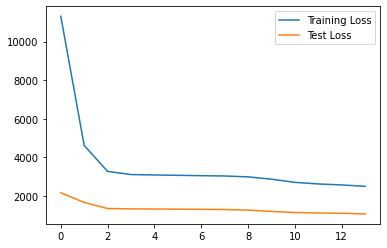

[15,     1] loss: 53.702
[15,     2] loss: 47.190
[15,     3] loss: 56.836
[15,     4] loss: 58.325
[15,     5] loss: 54.459
[15,     6] loss: 56.174
[15,     7] loss: 56.523
[15,     8] loss: 56.696
[15,     9] loss: 57.738
[15,    10] loss: 53.087
[15,    11] loss: 57.176
[15,    12] loss: 50.273
[15,    13] loss: 57.015
[15,    14] loss: 59.735
[15,    15] loss: 51.535
[15,    16] loss: 59.885
[15,    17] loss: 52.366
[15,    18] loss: 57.852
[15,    19] loss: 52.986
[15,    20] loss: 56.034
[15,    21] loss: 54.400
[15,    22] loss: 52.552
[15,    23] loss: 60.398
[15,    24] loss: 58.079
[15,    25] loss: 53.819
[15,    26] loss: 53.699
[15,    27] loss: 60.697
[15,    28] loss: 59.932
[15,    29] loss: 58.579
[15,    30] loss: 56.606
[15,    31] loss: 56.014
[15,    32] loss: 60.497
[15,    33] loss: 56.320
[15,    34] loss: 48.720
[15,    35] loss: 57.104
[15,    36] loss: 59.251
[15,    37] loss: 51.367
[15,    38] loss: 56.989
[15,    39] loss: 48.408
[15,    40] loss: 58.463


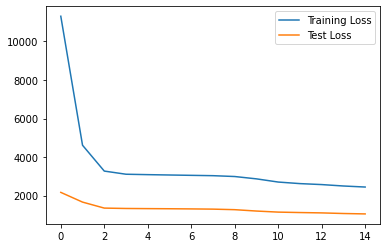

[16,     1] loss: 52.570
[16,     2] loss: 46.382
[16,     3] loss: 55.359
[16,     4] loss: 55.840
[16,     5] loss: 52.871
[16,     6] loss: 54.611
[16,     7] loss: 53.402
[16,     8] loss: 54.291
[16,     9] loss: 56.764
[16,    10] loss: 51.225
[16,    11] loss: 55.591
[16,    12] loss: 50.335
[16,    13] loss: 54.314
[16,    14] loss: 57.924
[16,    15] loss: 51.331
[16,    16] loss: 58.309
[16,    17] loss: 52.746
[16,    18] loss: 57.419
[16,    19] loss: 51.094
[16,    20] loss: 56.415
[16,    21] loss: 54.031
[16,    22] loss: 50.649
[16,    23] loss: 60.021
[16,    24] loss: 57.116
[16,    25] loss: 53.019
[16,    26] loss: 53.196
[16,    27] loss: 59.339
[16,    28] loss: 58.203
[16,    29] loss: 57.006
[16,    30] loss: 55.318
[16,    31] loss: 54.085
[16,    32] loss: 58.558
[16,    33] loss: 55.132
[16,    34] loss: 47.809
[16,    35] loss: 55.516
[16,    36] loss: 58.132
[16,    37] loss: 49.911
[16,    38] loss: 55.178
[16,    39] loss: 47.963
[16,    40] loss: 56.759


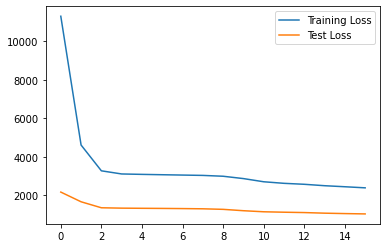

[17,     1] loss: 51.628
[17,     2] loss: 45.447
[17,     3] loss: 54.389
[17,     4] loss: 54.748
[17,     5] loss: 51.961
[17,     6] loss: 53.769
[17,     7] loss: 52.408
[17,     8] loss: 53.411
[17,     9] loss: 55.705
[17,    10] loss: 50.169
[17,    11] loss: 54.692
[17,    12] loss: 49.348
[17,    13] loss: 53.195
[17,    14] loss: 56.960
[17,    15] loss: 50.062
[17,    16] loss: 57.500
[17,    17] loss: 51.932
[17,    18] loss: 55.793
[17,    19] loss: 51.044
[17,    20] loss: 55.004
[17,    21] loss: 51.931
[17,    22] loss: 50.096
[17,    23] loss: 58.009
[17,    24] loss: 55.878
[17,    25] loss: 52.064
[17,    26] loss: 51.945
[17,    27] loss: 58.758
[17,    28] loss: 57.043
[17,    29] loss: 56.158
[17,    30] loss: 54.663
[17,    31] loss: 53.261
[17,    32] loss: 57.437
[17,    33] loss: 54.105
[17,    34] loss: 46.992
[17,    35] loss: 54.348
[17,    36] loss: 57.150
[17,    37] loss: 49.067
[17,    38] loss: 54.278
[17,    39] loss: 47.299
[17,    40] loss: 55.449


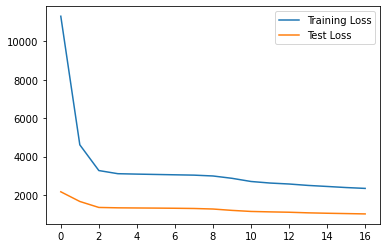

[18,     1] loss: 50.615
[18,     2] loss: 44.919
[18,     3] loss: 53.602
[18,     4] loss: 53.766
[18,     5] loss: 51.315
[18,     6] loss: 52.819
[18,     7] loss: 51.589
[18,     8] loss: 53.263
[18,     9] loss: 54.992
[18,    10] loss: 48.906
[18,    11] loss: 54.305
[18,    12] loss: 48.230
[18,    13] loss: 53.017
[18,    14] loss: 56.182
[18,    15] loss: 48.815
[18,    16] loss: 57.669
[18,    17] loss: 50.030
[18,    18] loss: 55.615
[18,    19] loss: 51.299
[18,    20] loss: 52.666
[18,    21] loss: 51.922
[18,    22] loss: 50.272
[18,    23] loss: 56.399
[18,    24] loss: 57.465
[18,    25] loss: 50.952
[18,    26] loss: 53.052
[18,    27] loss: 58.848
[18,    28] loss: 56.442
[18,    29] loss: 56.940
[18,    30] loss: 53.033
[18,    31] loss: 54.174
[18,    32] loss: 56.719
[18,    33] loss: 53.329
[18,    34] loss: 47.017
[18,    35] loss: 52.983
[18,    36] loss: 56.628
[18,    37] loss: 48.190
[18,    38] loss: 52.921
[18,    39] loss: 46.511
[18,    40] loss: 53.917


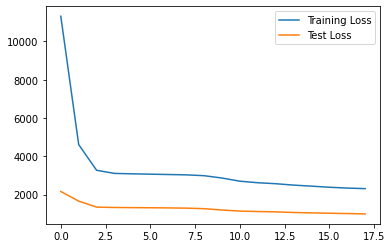

[19,     1] loss: 49.465
[19,     2] loss: 44.329
[19,     3] loss: 52.292
[19,     4] loss: 53.169
[19,     5] loss: 49.666
[19,     6] loss: 52.598
[19,     7] loss: 50.607
[19,     8] loss: 52.784
[19,     9] loss: 53.280
[19,    10] loss: 48.542
[19,    11] loss: 53.721
[19,    12] loss: 46.986
[19,    13] loss: 52.636
[19,    14] loss: 53.272
[19,    15] loss: 48.813
[19,    16] loss: 55.390
[19,    17] loss: 49.167
[19,    18] loss: 54.577
[19,    19] loss: 48.443
[19,    20] loss: 52.353
[19,    21] loss: 49.253
[19,    22] loss: 48.420
[19,    23] loss: 55.174
[19,    24] loss: 53.891
[19,    25] loss: 49.738
[19,    26] loss: 50.465
[19,    27] loss: 55.827
[19,    28] loss: 55.645
[19,    29] loss: 52.729
[19,    30] loss: 52.165
[19,    31] loss: 51.494
[19,    32] loss: 55.045
[19,    33] loss: 52.114
[19,    34] loss: 45.140
[19,    35] loss: 51.822
[19,    36] loss: 54.940
[19,    37] loss: 47.484
[19,    38] loss: 51.276
[19,    39] loss: 45.726
[19,    40] loss: 52.347


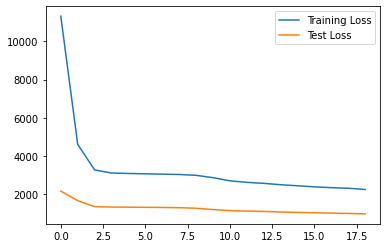

[20,     1] loss: 47.916
[20,     2] loss: 42.953
[20,     3] loss: 50.998
[20,     4] loss: 50.898
[20,     5] loss: 48.495
[20,     6] loss: 50.412
[20,     7] loss: 49.577
[20,     8] loss: 50.281
[20,     9] loss: 51.416
[20,    10] loss: 47.067
[20,    11] loss: 50.095
[20,    12] loss: 45.784
[20,    13] loss: 50.180
[20,    14] loss: 51.893
[20,    15] loss: 46.964
[20,    16] loss: 52.499
[20,    17] loss: 48.341
[20,    18] loss: 52.818
[20,    19] loss: 47.744
[20,    20] loss: 50.345
[20,    21] loss: 47.881
[20,    22] loss: 46.823
[20,    23] loss: 53.248
[20,    24] loss: 52.746
[20,    25] loss: 47.858
[20,    26] loss: 48.987
[20,    27] loss: 53.804
[20,    28] loss: 53.368
[20,    29] loss: 51.158
[20,    30] loss: 50.202
[20,    31] loss: 50.136
[20,    32] loss: 53.305
[20,    33] loss: 50.201
[20,    34] loss: 43.579
[20,    35] loss: 49.998
[20,    36] loss: 53.690
[20,    37] loss: 45.500
[20,    38] loss: 49.944
[20,    39] loss: 44.263
[20,    40] loss: 51.099


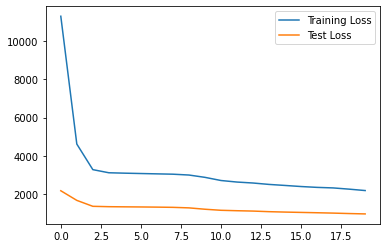

[21,     1] loss: 46.804
[21,     2] loss: 41.810
[21,     3] loss: 49.598
[21,     4] loss: 49.392
[21,     5] loss: 47.425
[21,     6] loss: 48.966
[21,     7] loss: 48.307
[21,     8] loss: 49.319
[21,     9] loss: 49.862
[21,    10] loss: 45.496
[21,    11] loss: 48.621
[21,    12] loss: 44.132
[21,    13] loss: 48.845
[21,    14] loss: 50.251
[21,    15] loss: 45.503
[21,    16] loss: 51.459
[21,    17] loss: 46.973
[21,    18] loss: 51.771
[21,    19] loss: 46.089
[21,    20] loss: 49.040
[21,    21] loss: 46.561
[21,    22] loss: 45.373
[21,    23] loss: 51.938
[21,    24] loss: 51.267
[21,    25] loss: 46.710
[21,    26] loss: 48.168
[21,    27] loss: 52.611
[21,    28] loss: 51.620
[21,    29] loss: 50.520
[21,    30] loss: 48.954
[21,    31] loss: 48.903
[21,    32] loss: 52.435
[21,    33] loss: 48.826
[21,    34] loss: 42.430
[21,    35] loss: 49.157
[21,    36] loss: 52.297
[21,    37] loss: 44.487
[21,    38] loss: 49.089
[21,    39] loss: 43.257
[21,    40] loss: 50.210


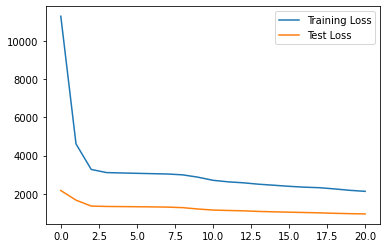

[22,     1] loss: 46.050
[22,     2] loss: 41.195
[22,     3] loss: 48.734
[22,     4] loss: 48.310
[22,     5] loss: 46.498
[22,     6] loss: 47.979
[22,     7] loss: 47.534
[22,     8] loss: 48.298
[22,     9] loss: 49.001
[22,    10] loss: 44.523
[22,    11] loss: 47.462
[22,    12] loss: 43.259
[22,    13] loss: 47.862
[22,    14] loss: 49.438
[22,    15] loss: 44.594
[22,    16] loss: 50.508
[22,    17] loss: 46.302
[22,    18] loss: 50.961
[22,    19] loss: 45.604
[22,    20] loss: 48.030
[22,    21] loss: 45.614
[22,    22] loss: 44.677
[22,    23] loss: 50.915
[22,    24] loss: 50.412
[22,    25] loss: 46.048
[22,    26] loss: 47.169
[22,    27] loss: 51.630
[22,    28] loss: 50.542
[22,    29] loss: 49.282
[22,    30] loss: 48.142
[22,    31] loss: 48.040
[22,    32] loss: 51.473
[22,    33] loss: 48.323
[22,    34] loss: 41.782
[22,    35] loss: 48.476
[22,    36] loss: 51.628
[22,    37] loss: 43.678
[22,    38] loss: 48.327
[22,    39] loss: 42.736
[22,    40] loss: 49.102


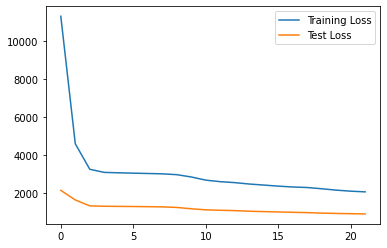

[23,     1] loss: 45.358
[23,     2] loss: 40.702
[23,     3] loss: 48.036
[23,     4] loss: 47.318
[23,     5] loss: 45.786
[23,     6] loss: 47.199
[23,     7] loss: 46.625
[23,     8] loss: 47.410
[23,     9] loss: 48.402
[23,    10] loss: 43.507
[23,    11] loss: 46.547
[23,    12] loss: 42.554
[23,    13] loss: 46.945
[23,    14] loss: 48.798
[23,    15] loss: 43.675
[23,    16] loss: 49.435
[23,    17] loss: 45.770
[23,    18] loss: 49.980
[23,    19] loss: 44.791
[23,    20] loss: 47.358
[23,    21] loss: 44.442
[23,    22] loss: 43.853
[23,    23] loss: 50.094
[23,    24] loss: 49.178
[23,    25] loss: 45.209
[23,    26] loss: 46.352
[23,    27] loss: 50.056
[23,    28] loss: 49.449
[23,    29] loss: 48.235
[23,    30] loss: 46.880
[23,    31] loss: 47.357
[23,    32] loss: 50.498
[23,    33] loss: 47.244
[23,    34] loss: 41.190
[23,    35] loss: 47.524
[23,    36] loss: 50.764
[23,    37] loss: 42.959
[23,    38] loss: 47.395
[23,    39] loss: 41.988
[23,    40] loss: 48.168


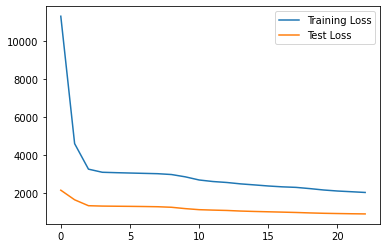

[24,     1] loss: 44.830
[24,     2] loss: 40.006
[24,     3] loss: 47.581
[24,     4] loss: 46.556
[24,     5] loss: 45.099
[24,     6] loss: 46.611
[24,     7] loss: 45.727
[24,     8] loss: 46.907
[24,     9] loss: 47.724
[24,    10] loss: 42.764
[24,    11] loss: 45.728
[24,    12] loss: 42.024
[24,    13] loss: 46.034
[24,    14] loss: 48.139
[24,    15] loss: 43.050
[24,    16] loss: 48.399
[24,    17] loss: 45.304
[24,    18] loss: 49.019
[24,    19] loss: 44.052
[24,    20] loss: 46.547
[24,    21] loss: 43.866
[24,    22] loss: 43.121
[24,    23] loss: 49.369
[24,    24] loss: 48.307
[24,    25] loss: 44.715
[24,    26] loss: 45.729
[24,    27] loss: 49.107
[24,    28] loss: 48.533
[24,    29] loss: 47.494
[24,    30] loss: 46.302
[24,    31] loss: 46.810
[24,    32] loss: 49.728
[24,    33] loss: 46.605
[24,    34] loss: 40.813
[24,    35] loss: 46.760
[24,    36] loss: 50.162
[24,    37] loss: 42.603
[24,    38] loss: 46.776
[24,    39] loss: 41.461
[24,    40] loss: 47.418


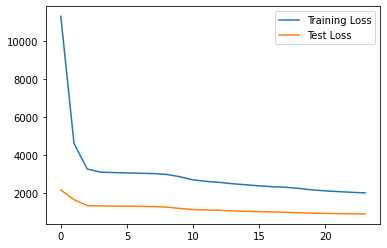

[25,     1] loss: 44.284
[25,     2] loss: 39.420
[25,     3] loss: 47.015
[25,     4] loss: 45.868
[25,     5] loss: 44.536
[25,     6] loss: 45.888
[25,     7] loss: 45.037
[25,     8] loss: 46.557
[25,     9] loss: 47.110
[25,    10] loss: 42.115
[25,    11] loss: 45.112
[25,    12] loss: 41.579
[25,    13] loss: 45.411
[25,    14] loss: 47.549
[25,    15] loss: 42.500
[25,    16] loss: 47.609
[25,    17] loss: 44.780
[25,    18] loss: 48.324
[25,    19] loss: 43.476
[25,    20] loss: 45.677
[25,    21] loss: 43.217
[25,    22] loss: 42.578
[25,    23] loss: 48.645
[25,    24] loss: 47.600
[25,    25] loss: 44.203
[25,    26] loss: 45.070
[25,    27] loss: 48.412
[25,    28] loss: 47.634
[25,    29] loss: 46.540
[25,    30] loss: 45.467
[25,    31] loss: 46.240
[25,    32] loss: 49.045
[25,    33] loss: 45.889
[25,    34] loss: 40.275
[25,    35] loss: 46.177
[25,    36] loss: 49.438
[25,    37] loss: 41.862
[25,    38] loss: 46.217
[25,    39] loss: 41.103
[25,    40] loss: 46.766


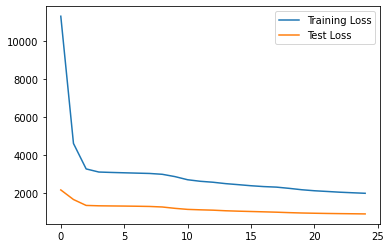

[26,     1] loss: 43.781
[26,     2] loss: 38.988
[26,     3] loss: 46.322
[26,     4] loss: 45.033
[26,     5] loss: 43.877
[26,     6] loss: 45.086
[26,     7] loss: 44.317
[26,     8] loss: 45.731
[26,     9] loss: 46.271
[26,    10] loss: 41.591
[26,    11] loss: 44.330
[26,    12] loss: 41.153
[26,    13] loss: 44.907
[26,    14] loss: 46.970
[26,    15] loss: 41.992
[26,    16] loss: 47.064
[26,    17] loss: 44.135
[26,    18] loss: 47.691
[26,    19] loss: 42.864
[26,    20] loss: 44.992
[26,    21] loss: 42.684
[26,    22] loss: 42.031
[26,    23] loss: 47.922
[26,    24] loss: 47.010
[26,    25] loss: 43.654
[26,    26] loss: 44.517
[26,    27] loss: 47.745
[26,    28] loss: 46.754
[26,    29] loss: 45.983
[26,    30] loss: 44.788
[26,    31] loss: 45.824
[26,    32] loss: 48.419
[26,    33] loss: 45.521
[26,    34] loss: 39.747
[26,    35] loss: 45.887
[26,    36] loss: 48.798
[26,    37] loss: 41.364
[26,    38] loss: 45.549
[26,    39] loss: 40.807
[26,    40] loss: 46.407


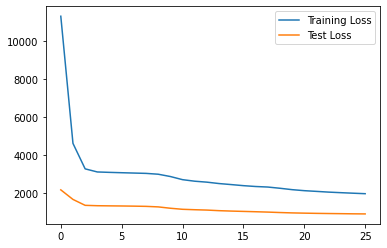

[27,     1] loss: 43.315
[27,     2] loss: 38.937
[27,     3] loss: 45.557
[27,     4] loss: 44.495
[27,     5] loss: 43.173
[27,     6] loss: 44.235
[27,     7] loss: 43.645
[27,     8] loss: 45.174
[27,     9] loss: 45.769
[27,    10] loss: 41.035
[27,    11] loss: 43.851
[27,    12] loss: 40.460
[27,    13] loss: 44.591
[27,    14] loss: 46.079
[27,    15] loss: 41.733
[27,    16] loss: 46.115
[27,    17] loss: 43.611
[27,    18] loss: 47.228
[27,    19] loss: 42.314
[27,    20] loss: 44.401
[27,    21] loss: 42.065
[27,    22] loss: 41.628
[27,    23] loss: 47.261
[27,    24] loss: 46.332
[27,    25] loss: 42.885
[27,    26] loss: 43.946
[27,    27] loss: 46.848
[27,    28] loss: 45.948
[27,    29] loss: 45.164
[27,    30] loss: 44.200
[27,    31] loss: 45.278
[27,    32] loss: 48.029
[27,    33] loss: 44.668
[27,    34] loss: 38.941
[27,    35] loss: 45.285
[27,    36] loss: 48.097
[27,    37] loss: 41.044
[27,    38] loss: 44.589
[27,    39] loss: 40.467
[27,    40] loss: 45.780


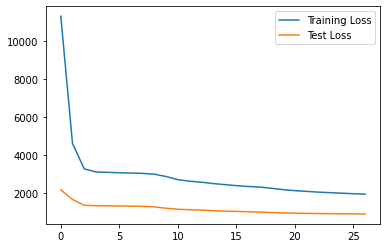

[28,     1] loss: 43.106
[28,     2] loss: 38.637
[28,     3] loss: 45.311
[28,     4] loss: 43.962
[28,     5] loss: 42.560
[28,     6] loss: 43.599
[28,     7] loss: 43.191
[28,     8] loss: 44.637
[28,     9] loss: 45.129
[28,    10] loss: 40.465
[28,    11] loss: 42.943
[28,    12] loss: 40.218
[28,    13] loss: 43.864
[28,    14] loss: 45.499
[28,    15] loss: 41.141
[28,    16] loss: 45.390
[28,    17] loss: 42.978
[28,    18] loss: 46.758
[28,    19] loss: 41.765
[28,    20] loss: 43.830
[28,    21] loss: 41.470
[28,    22] loss: 40.948
[28,    23] loss: 46.582
[28,    24] loss: 45.632
[28,    25] loss: 42.389
[28,    26] loss: 43.288
[28,    27] loss: 45.999
[28,    28] loss: 45.075
[28,    29] loss: 44.753
[28,    30] loss: 43.737
[28,    31] loss: 44.868
[28,    32] loss: 47.253
[28,    33] loss: 43.945
[28,    34] loss: 38.502
[28,    35] loss: 44.820
[28,    36] loss: 47.445
[28,    37] loss: 40.436
[28,    38] loss: 44.007
[28,    39] loss: 40.386
[28,    40] loss: 45.365


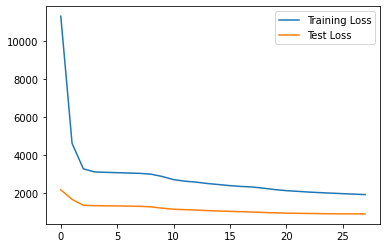

[29,     1] loss: 42.746
[29,     2] loss: 37.695
[29,     3] loss: 44.192
[29,     4] loss: 43.141
[29,     5] loss: 41.939
[29,     6] loss: 43.048
[29,     7] loss: 42.641
[29,     8] loss: 43.993
[29,     9] loss: 44.535
[29,    10] loss: 40.109
[29,    11] loss: 42.439
[29,    12] loss: 39.691
[29,    13] loss: 43.648
[29,    14] loss: 44.891
[29,    15] loss: 40.876
[29,    16] loss: 44.758
[29,    17] loss: 42.427
[29,    18] loss: 46.172
[29,    19] loss: 41.292
[29,    20] loss: 43.286
[29,    21] loss: 41.679
[29,    22] loss: 41.155
[29,    23] loss: 45.895
[29,    24] loss: 45.205
[29,    25] loss: 42.367
[29,    26] loss: 43.232
[29,    27] loss: 45.688
[29,    28] loss: 44.737
[29,    29] loss: 44.255
[29,    30] loss: 43.768
[29,    31] loss: 44.229
[29,    32] loss: 46.433
[29,    33] loss: 44.522
[29,    34] loss: 39.413
[29,    35] loss: 44.345
[29,    36] loss: 47.490
[29,    37] loss: 40.513
[29,    38] loss: 44.038
[29,    39] loss: 39.826
[29,    40] loss: 45.460


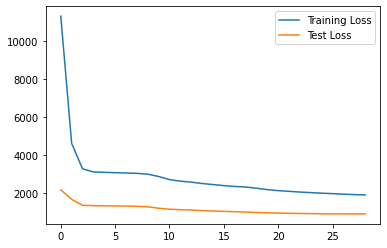

[30,     1] loss: 42.569
[30,     2] loss: 37.745
[30,     3] loss: 43.862
[30,     4] loss: 43.442
[30,     5] loss: 42.213
[30,     6] loss: 42.886
[30,     7] loss: 43.252
[30,     8] loss: 43.295
[30,     9] loss: 44.694
[30,    10] loss: 40.037
[30,    11] loss: 42.095
[30,    12] loss: 39.537
[30,    13] loss: 43.142
[30,    14] loss: 44.494
[30,    15] loss: 40.438
[30,    16] loss: 44.769
[30,    17] loss: 42.059
[30,    18] loss: 45.450
[30,    19] loss: 40.703
[30,    20] loss: 43.168
[30,    21] loss: 40.206
[30,    22] loss: 39.806
[30,    23] loss: 45.153
[30,    24] loss: 44.463
[30,    25] loss: 41.415
[30,    26] loss: 42.181
[30,    27] loss: 44.766
[30,    28] loss: 43.743
[30,    29] loss: 43.602
[30,    30] loss: 42.055
[30,    31] loss: 43.353
[30,    32] loss: 46.356
[30,    33] loss: 42.586
[30,    34] loss: 37.733
[30,    35] loss: 43.476
[30,    36] loss: 46.030
[30,    37] loss: 39.643
[30,    38] loss: 42.913
[30,    39] loss: 38.947
[30,    40] loss: 43.740


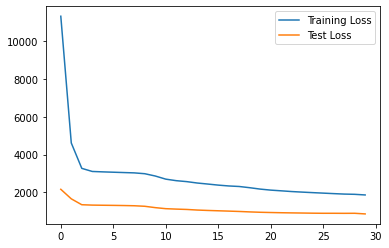

Finished Training


In [39]:
train_loss_graph = []
test_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)
          

print('Finished Training')

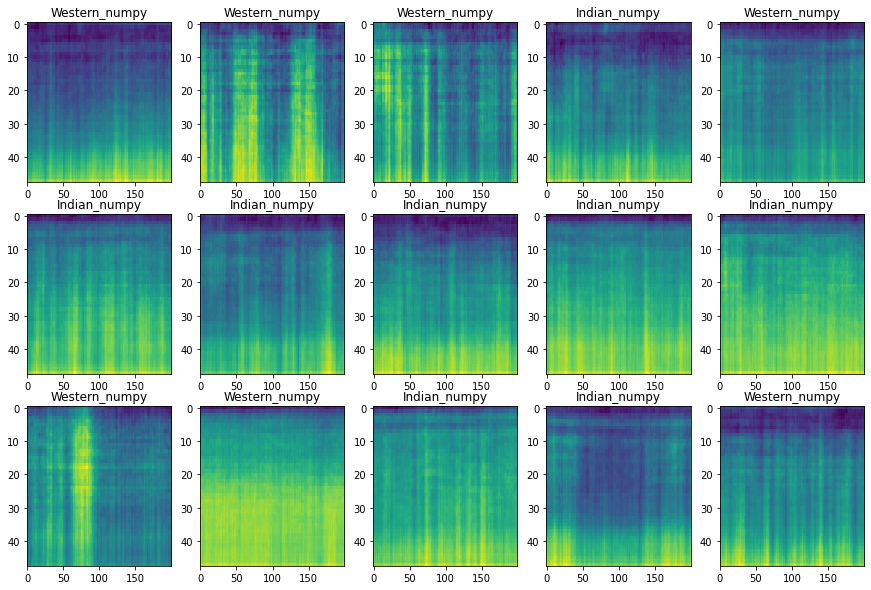

In [40]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

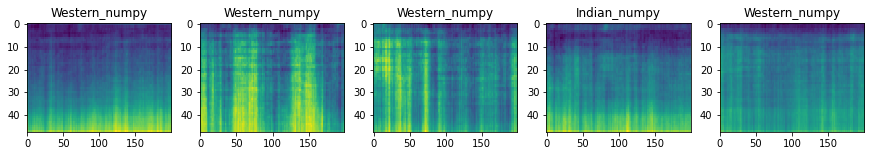

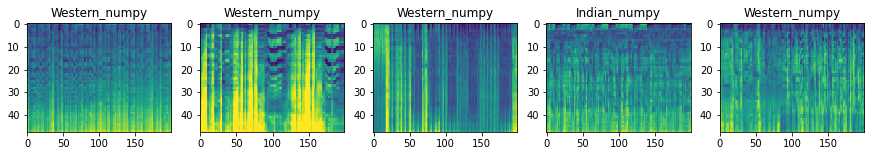

In [52]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [ ]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [ ]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

In [ ]:
combined_dataset = MEL_Dataset(data,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# get some random training images
dataiter = iter(combinedloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        print(image.shape)
        output_l2, output_l1 = net.encoder(image.unsqueeze(dim=0))
        print(output_l2.shape)
        print(output_l1.shape)